In [1]:
import pandas as pd

df_movies = pd.read_csv('movies.csv')
df_ratings = pd.read_csv('ratings.csv')

df_movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<AxesSubplot:xlabel='rating', ylabel='Count'>

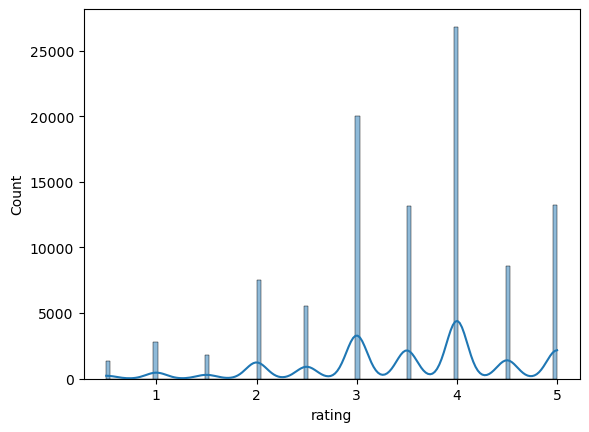

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_ratings, x='rating', kde=True)

In [3]:
print(f"Number of movies: {df_ratings.movieId.nunique()}")
print(f"Number of users: {df_ratings.userId.nunique()}")
print(f"Number of ratings: {df_ratings.shape[0]}")
print(f"Possible ratings: {df_ratings.movieId.nunique() * df_ratings.userId.nunique()}")


Number of movies: 9724
Number of users: 610
Number of ratings: 100836
Possible ratings: 5931640


In [4]:
print('Min:\t\t', df_ratings['movieId'].value_counts().min())
print('Quartile 1:\t', df_ratings['movieId'].value_counts().quantile(.25))
print('Median:\t\t', df_ratings['movieId'].value_counts().quantile(.5))
print('Quartile 3:\t', df_ratings['movieId'].value_counts().quantile(.75))
print('Max:\t\t', df_ratings['movieId'].value_counts().max())

Min:		 1
Quartile 1:	 1.0
Median:		 3.0
Quartile 3:	 9.0
Max:		 329


In [5]:
# drop all movies that have less than 9 ratings to get a smaller dataset
value_counts = df_ratings.movieId.value_counts()
keep_list = value_counts[value_counts >= 9]
df_ratings = df_ratings.loc[df_ratings.movieId.isin(keep_list.index)]
df_ratings.shape

(82664, 4)

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

# count num of users and items
U = df_ratings['userId'].nunique()
I = df_ratings['movieId'].nunique()

# match actual user and item IDs with consecutive integers from 0 to n
user_mapper = dict(zip(np.unique(df_ratings['userId']), list(range(U))))
item_mapper = dict(zip(np.unique(df_ratings['movieId']), list(range(I))))

# reverse the mapping
user_inv_mapper = dict(zip(list(range(U)), np.unique(df_ratings['userId'])))
item_inv_mapper = dict(zip(list(range(I)), np.unique(df_ratings['movieId'])))

# create lists of users/items for each rating
user_index = [user_mapper[i] for i in df_ratings['userId']]
item_index = [item_mapper[i] for i in df_ratings['movieId']]

X = csr_matrix((df_ratings['rating'], (item_index, user_index)), shape=(I, U))

print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 82664 stored elements and shape (2441, 610)>
  Coords	Values
  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (2438, 600)	4.5
  (2439, 61)	3.5
  (2439, 97)	3.0
  (2439, 152)	0.5
  (2439, 209)	4.5
  (2439, 248)	4.5
  (2439, 379)	0.5
  (2439, 413)	4.5
  (2439, 513)	2.0
  (2439, 514)	4.0
  (2439, 566)	2.0
  (2439, 585)	5.0
  (2439, 595)	3.5
  (2440, 24)	5.0
  (2440, 61)	4.0
  (2440, 97)	5.0
  (2440, 232)	2.5
  (2440, 247)	4.5
  (2440, 248)	5.0
  (2440, 304)	5.0
  (2440, 330)	4.0
  (2440, 337)	1.0
  (2440, 379)	3.0
  (2440, 513)	3.5
  (2440, 585)	4.0


In [7]:
def create_matrix(df, user, item, rating):
    import numpy as np
    from scipy.sparse import csr_matrix

    U = df[user].nunique()  # Number of users for the matrix
    I = df[item].nunique()  # Number of items for the matrix

    # Map user and movie IDs to matrix indices
    user_mapper = dict(zip(np.unique(df[user]), list(range(U))))
    item_mapper = dict(zip(np.unique(df[item]), list(range(I))))

    # Map matrix indices back to IDs
    user_inv_mapper = dict(zip(list(range(U)), np.unique(df[user])))
    item_inv_mapper = dict(zip(list(range(I)), np.unique(df[item])))

    # Create a list of index values for the csr_matrix for users and movies
    user_index = [user_mapper[i] for i in df[user]]
    item_index = [item_mapper[i] for i in df[item]]

    # Build the final matrix which will look like: (movieId, userId) rating
    X = csr_matrix((df[rating], (item_index, user_index)), shape=(I, U))

    return X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper

X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_matrix(df_ratings, 'userId', 'movieId', 'rating')

In [8]:
def recommend(itemId, X, item_mapper, item_inv_mapper, k, metric='cosine', messages=True):
  from sklearn.neighbors import NearestNeighbors

  rec_ids = []                # Make a list for the recommended item IDs we'll get later
  item = item_mapper[itemId]  # Get the index of the movie ID passed into the function
  item_vector = X[item]       # Get the vector of user ratings for the movie ID passed into the function

  # Fit the clustering algorithm based on the user-item matrix X
  knn = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric).fit(X)

  # Call the trained knn cluster model to return the nearest neighbors of the item_vector passed in
  rec = knn.kneighbors(item_vector.reshape(1,-1), return_distance=True)
  rec_indeces = rec[1][0]     # Parse out the list of indeces of the recommended items
  rec_distances = rec[0][0]   # Parse out the recommendation strength calculated as the distance from the cluster center
  rec_distances = np.delete(rec_distances, 0) # Drop the first number in the list because it is the distance of itemId from itself

  # We need to replace the recommended item indeces with their original item IDs
  for i in range(1, knn.n_neighbors): # n_neighbors is the number of neighbors to return
    rec_ids.append(item_inv_mapper[rec_indeces[i]])

  # It may help to see what this is. The distance list is first and the recommended item indeces are second
  if messages:
    print(f'List of recommended item indeces:\n{rec_indeces}\n')
    print(f'List of recommended item IDs:\n{rec_ids}\n')
    print(f'List of recommended item similarity to selected item:\n{rec_distances}\n')

  # Return two lists: the original item IDs of the recommendations and their similarity scores
  return rec_ids, rec_distances

In [9]:
# Use any movie id here to get recommendations
movie_id = 95
rec_ids, rec_distances = recommend(movie_id, X, item_mapper, item_inv_mapper, k=10)

print(f"If you like {df_movies.loc[movie_id, 'title']}, you may also enjoy:\n")
print(f"\t{df_movies.loc[rec_ids, 'title']}")

List of recommended item indeces:
[ 55 340 324 246 336 304  64   4 323 198  69]

List of recommended item IDs:
[786, 736, 494, 780, 648, 112, 6, 733, 376, 141]

List of recommended item similarity to selected item:
[0.43563287 0.45943536 0.46336037 0.5197952  0.52763157 0.53059381
 0.5364971  0.5491601  0.55511851 0.57265249]

If you like Muppet Treasure Island (1996), you may also enjoy:

	786                                         Dumbo (1941)
736                                Penny Serenade (1941)
494                             Little Big League (1994)
780                                    Cinderella (1950)
648                                Chain Reaction (1996)
112                                          Jade (1995)
6                                         Sabrina (1995)
733                         It's a Wonderful Life (1946)
376    City Slickers II: The Legend of Curly's Gold (...
141              Free Willy 2: The Adventure Home (1995)
Name: title, dtype: object


DAY 2

In [17]:
user_id = 150
k = 20

df_user_ratings = df_ratings[df_ratings['userId'] == user_id].sort_values(by=['rating'], ascending=False)
df_user_ratings = df_user_ratings.head(3)
df_user_ratings

df_results = pd.DataFrame(columns=['distance'])

for row in df_user_ratings.itertuples():
    rec_ids, rec_distances = recommend(row.movieId, X, item_mapper, item_inv_mapper, k=k, messages=False)
    for i, rec_id in enumerate(rec_ids):
        df_results.at[rec_id, 'distance'] = rec_distances[i]


df_results.sort_values(by=['distance'])

,distance
1374,0.403411
296,0.432302
589,0.437787
47,0.45821
608,0.465662
1375,0.479482
1376,0.482495
457,0.484857
50,0.486052
480,0.486117


In [21]:
k = 5
df_recommendations = pd.DataFrame(columns=['title'], index=item_mapper)
# df_movies.set_index('movieId', inplace=True)

for row in df_recommendations.itertuples():
    rec_ids, rec_distances = recommend(row[0], X, item_mapper, item_inv_mapper, k=k, messages=False)
    df_recommendations.at[row[0], 'title'] = df_movies.at[row[0], 'title']
    for i, r in enumerate(rec_ids):
        df_recommendations.at[row[0], f'Recommendation {i + 1}'] = df_movies.at[r, 'title']

df_recommendations

,title,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5
1,Toy Story (1995),Toy Story 2 (1999),Jurassic Park (1993),Independence Day (a.k.a. ID4) (1996),Star Wars: Episode IV - A New Hope (1977),Forrest Gump (1994)
2,Jumanji (1995),"Lion King, The (1994)",Mrs. Doubtfire (1993),"Mask, The (1994)",Jurassic Park (1993),Home Alone (1990)
3,Grumpier Old Men (1995),Grumpy Old Men (1993),Striptease (1996),"Nutty Professor, The (1996)",Twister (1996),Father of the Bride Part II (1995)
5,Father of the Bride Part II (1995),Sabrina (1995),"Juror, The (1996)",Striptease (1996),Mr. Holland's Opus (1995),Grumpier Old Men (1995)
6,Heat (1995),"Rock, The (1996)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Léon: The Professional (a.k.a. The Professiona...,Casino (1995),Fargo (1996)
...,...,...,...,...,...,...
175303,It (2017),Prisoners (2013),We're the Millers (2013),The Hateful Eight (2015),Now You See Me (2013),Pitch Perfect (2012)
176371,Blade Runner 2049 (2017),Dunkirk (2017),Thor: Ragnarok (2017),Guardians of the Galaxy 2 (2017),Wonder Woman (2017),Baby Driver (2017)
177765,Coco (2017),Guardians of the Galaxy 2 (2017),Thor: Ragnarok (2017),Ratatouille (2007),Star Wars: The Last Jedi (2017),Deadpool 2 (2018)
179819,Star Wars: The Last Jedi (2017),Untitled Spider-Man Reboot (2017),Black Panther (2017),Thor: Ragnarok (2017),Guardians of the Galaxy 2 (2017),X-Men: Apocalypse (2016)
